In [4]:
import numpy as np
import os

from type_definitions.test_case import TestCase_ACAS
from type_definitions.test_result import TestResult_ACAS
from type_definitions.utils import *
from sklearn.mixture import GaussianMixture
from sklearn.manifold import MDS
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [5]:
seed = 100
save_plot = False
use_cached_distance_matrix = True

In [7]:
np.random.seed(seed)

cases = generate_cases_acasxu(50)
results = evaluate_cases_acasxu(cases)
trajectories = [r.trajectory for r in results if not r.simulation_failed]
valid_results = [r for r in results if not r.simulation_failed]
print(f"Generated {len(trajectories)} valid trajectories")
print(
    f"Crashed: {sum(1 for r in valid_results if r.crashed)}, Safe: {sum(1 for r in valid_results if not r.crashed)}"
)

Generated 42 valid trajectories
Crashed: 14, Safe: 28


In [8]:
os.makedirs("cache", exist_ok=True)
distance_matrix_file = (
    f"cache/altitude_distance_matrix_acasxu_seed{seed}_size{len(trajectories)}.npy"
)

if use_cached_distance_matrix and os.path.exists(distance_matrix_file):
    print(f"Loading altitude-based distance matrix from {distance_matrix_file}")
    distance_matrix = np.load(distance_matrix_file)
else:
    print("Calculating pairwise altitude distances...")
    distance_matrix = pairwise_altitude_distances(trajectories)
    np.save(distance_matrix_file, distance_matrix)
    print(f"Altitude distance matrix saved to {distance_matrix_file}")

print(f"Distance matrix shape: {distance_matrix.shape}")

Calculating pairwise altitude distances...
Altitude distance matrix saved to cache/altitude_distance_matrix_acasxu_seed100_size42.npy
Distance matrix shape: (42, 42)


In [9]:
# Apply MDS to convert altitude-based distance matrix to feature space
print("Applying MDS transformation...")
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=seed)
X_transformed = mds.fit_transform(distance_matrix)
print(f"MDS transformed features shape: {X_transformed.shape}")
print(f"MDS stress: {mds.stress_:.4f}")

Applying MDS transformation...
MDS transformed features shape: (42, 2)
MDS stress: 37644171.6107


/Users/aidanmaguire/code/f16GCAS/code/.venv/lib/python3.13/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


In [10]:
# Apply GMM clustering with n=5 components based on altitude trajectories
n_components = 4
print(f"Applying GMM clustering with {n_components} components...")
gmm = GaussianMixture(n_components=n_components, random_state=seed)
gmm.fit(X_transformed)

# Apply clustering
clusters = gmm.predict(X_transformed)
cluster_probs = gmm.predict_proba(X_transformed)
unique_clusters = np.unique(clusters)

Applying GMM clustering with 4 components...


In [12]:
# Calculate cluster statistics
for cluster_id in unique_clusters:
    cluster_mask = clusters == cluster_id
    cluster_results = [
        valid_results[i] for i in range(len(valid_results)) if cluster_mask[i]
    ]
    crashed_in_cluster = sum(1 for r in cluster_results if r.crashed)
    total_in_cluster = len(cluster_results)
    crash_rate = (
        (crashed_in_cluster / total_in_cluster) * 100 if total_in_cluster > 0 else 0
    )
    print(
        f"Cluster {cluster_id}: {crashed_in_cluster}/{total_in_cluster} crashed ({crash_rate:.2f}%)"
    )

Cluster 0: 9/10 crashed (90.00%)
Cluster 1: 2/13 crashed (15.38%)
Cluster 2: 0/3 crashed (0.00%)
Cluster 3: 3/16 crashed (18.75%)


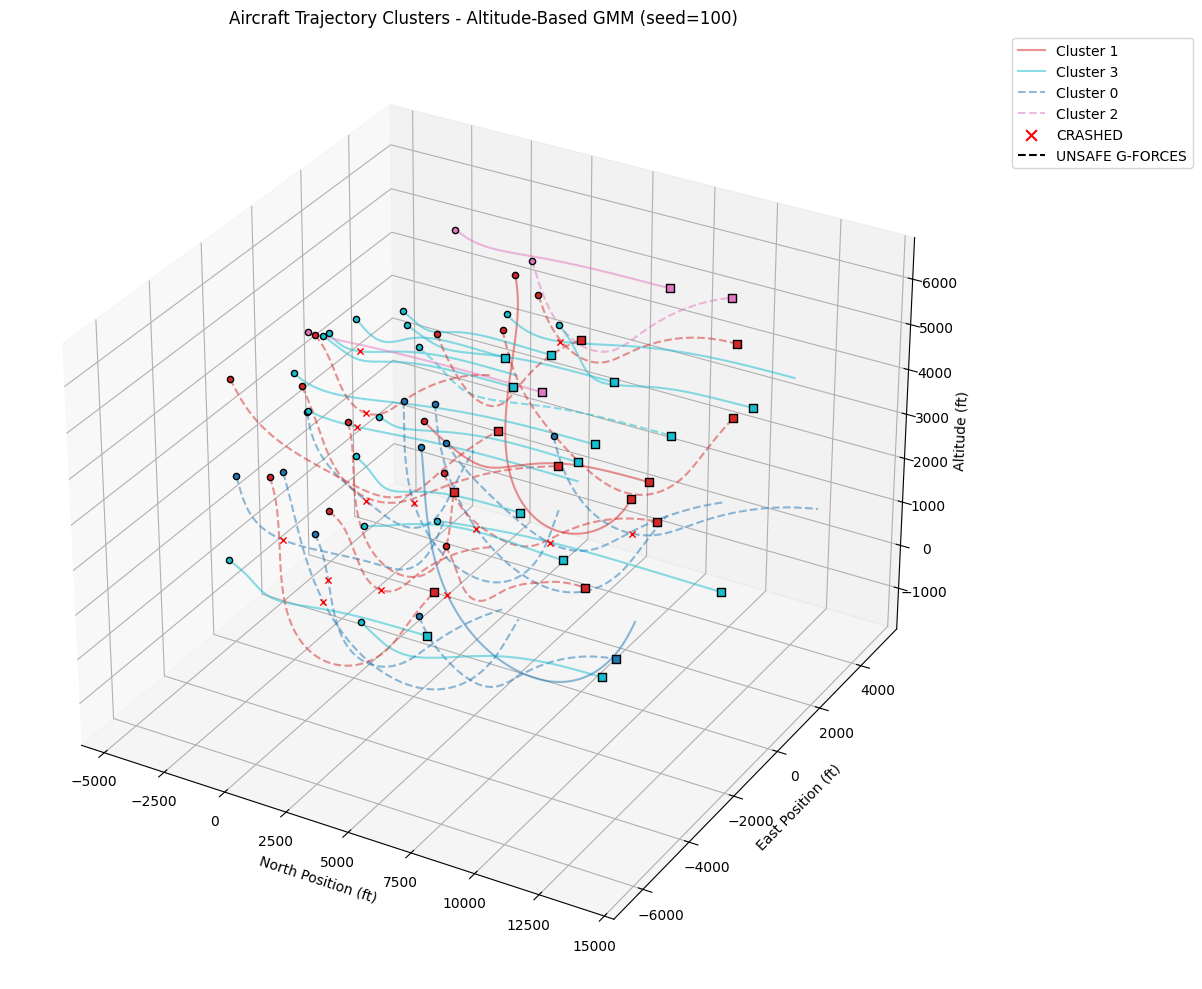

In [13]:
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection="3d")

colors = plt.get_cmap("tab10")(np.linspace(0, 1, len(unique_clusters)))

plotted_clusters = set()

for i, (traj, cluster_id, result) in enumerate(
    zip(trajectories, clusters, valid_results)
):
    color = colors[cluster_id % len(colors)]
    if cluster_id not in plotted_clusters:
        label = f"Cluster {cluster_id}"
        plotted_clusters.add(cluster_id)
    else:
        label = None

    # Check for unsafe g-forces
    has_unsafe_g = has_unsafe_gforces(traj)
    line_style = "--" if has_unsafe_g else "-"

    ax.plot(
        traj[:, 0],
        traj[:, 1],
        traj[:, 2],
        color=color,
        alpha=0.5,
        linewidth=1.5,
        linestyle=line_style,
        label=label,
    )

    # start point
    ax.scatter(
        traj[0, 0],
        traj[0, 1],
        traj[0, 2],
        color=color,
        s=20,
        marker="o",
        edgecolor="black",
        linewidth=1,
    )

    # end points
    if result.crashed:
        # Find the exact crashed point using first time alt <= 0
        crash_idx = np.where(traj[:, 2] <= 0)[0]
        if len(crash_idx) > 0:
            crash_idx = crash_idx[0]  # First occurrence
            crash_x = traj[crash_idx, 0]
            crash_y = traj[crash_idx, 1]
            crash_z = traj[crash_idx, 2]
        else:
            # Fallback to minimum altitude if no point <= 0
            min_alt_idx = np.argmin(result.trajectory[:, 2])
            crash_x = traj[min_alt_idx, 0]
            crash_y = traj[min_alt_idx, 1]
            crash_z = traj[min_alt_idx, 2]

        ax.scatter(
            crash_x,
            crash_y,
            crash_z,
            color="red",
            s=20,
            marker="x",
            linewidth=1,
        )
    else:
        # Safe landing point
        ax.scatter(
            traj[-1, 0],
            traj[-1, 1],
            traj[-1, 2],
            color=color,
            s=30,
            marker="s",
            edgecolor="black",
            linewidth=1,
        )

# Add legend for crashed trajectories
if any(result.crashed for result in valid_results):
    ax.scatter([], [], color="red", marker="x", s=60, label="CRASHED")

# Add legend for unsafe g-forces
if any(has_unsafe_gforces(traj) for traj in trajectories):
    ax.plot([], [], color="black", linestyle="--", label="UNSAFE G-FORCES")

ax.set_xlabel("North Position (ft)")
ax.set_ylabel("East Position (ft)")
ax.set_zlabel("Altitude (ft)")
ax.set_title(f"Aircraft Trajectory Clusters - Altitude-Based GMM (seed={seed})")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
if save_plot:
    plt.savefig(
        f"results/gmm_{n_components}_clusters_3d.png", dpi=300, bbox_inches="tight"
    )
    print(f"Plot saved to results/gmm_{n_components}_clusters_3d.png")

plt.show()

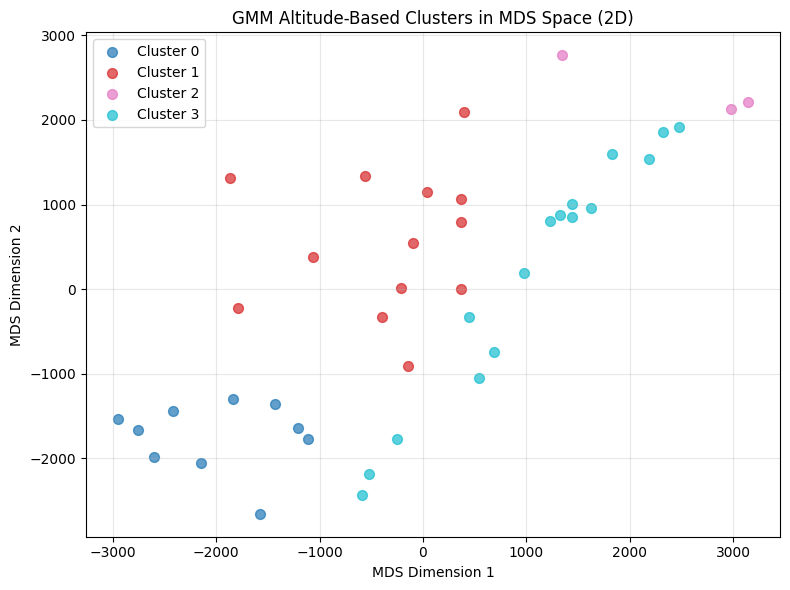

In [14]:
# Visualize clusters in MDS space
fig, ax1 = plt.subplots(1, 1, figsize=(8, 6))

colors = plt.get_cmap("tab10")(np.linspace(0, 1, len(unique_clusters)))

for cluster_id in unique_clusters:
    mask = clusters == cluster_id
    color = colors[cluster_id % len(colors)]

    # Plot first two MDS dimensions
    ax1.scatter(
        X_transformed[mask, 0],
        X_transformed[mask, 1],
        c=[color],
        label=f"Cluster {cluster_id}",
        alpha=0.7,
        s=50,
    )

ax1.set_xlabel("MDS Dimension 1")
ax1.set_ylabel("MDS Dimension 2")
ax1.set_title("GMM Altitude-Based Clusters in MDS Space (2D)")
ax1.legend()
ax1.grid(True, alpha=0.3)


plt.tight_layout()

if save_plot:
    plt.savefig(
        f"results/gmm_{n_components}_clusters_mds.png",
        dpi=300,
        bbox_inches="tight",
    )
    print(f"MDS plot saved to results/gmm_{n_components}_clusters_mds.png")

plt.show()

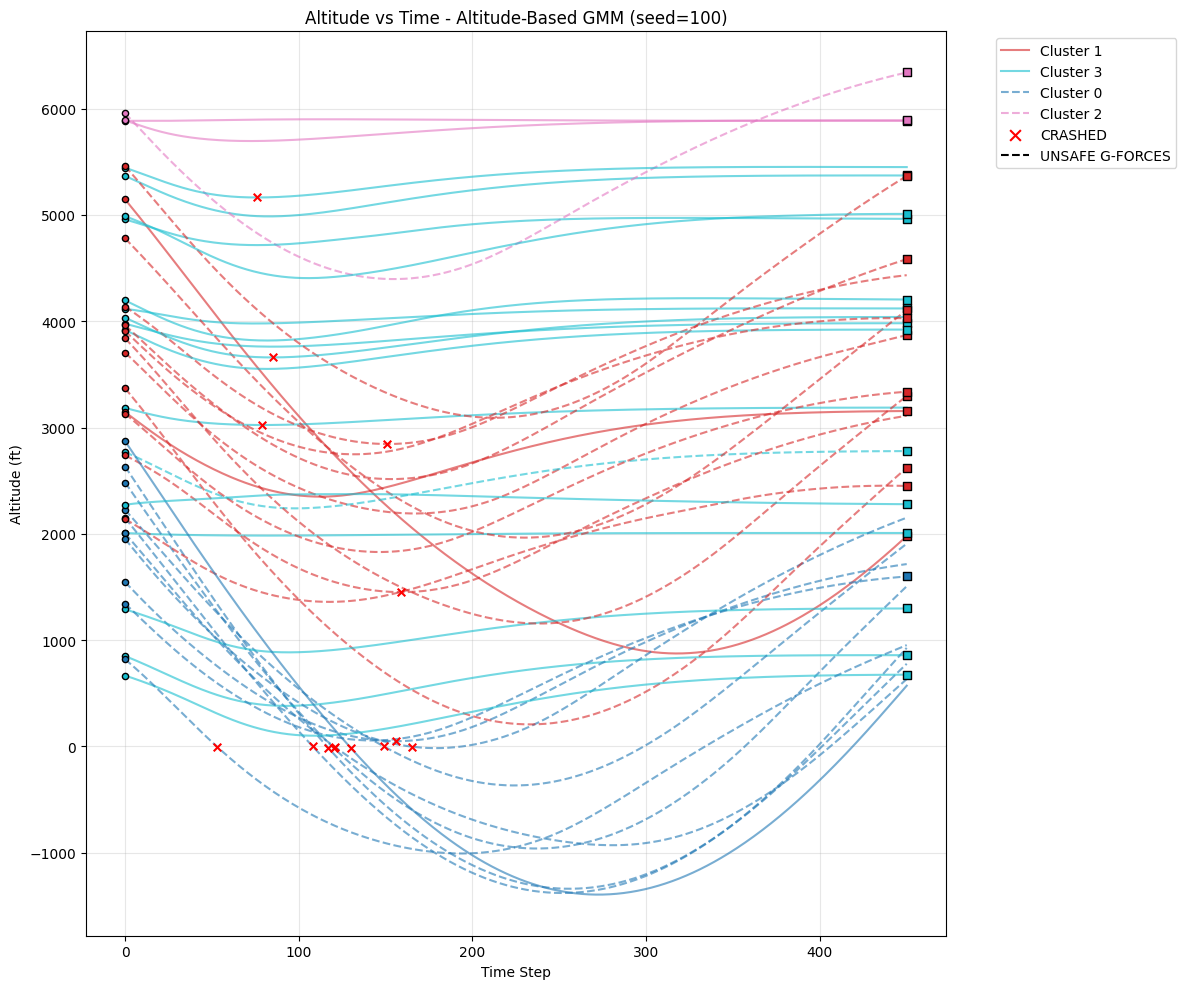

In [15]:
# Altitude vs Time Visualization
fig, ax = plt.subplots(figsize=(12, 10))

colors = plt.get_cmap("tab10")(np.linspace(0, 1, len(unique_clusters)))
plotted_clusters = set()

for traj, cluster_id, result in zip(trajectories, clusters, valid_results):
    color = colors[cluster_id % len(colors)]
    label = f"Cluster {cluster_id}" if cluster_id not in plotted_clusters else None
    plotted_clusters.add(cluster_id)

    # Style for unsafe g-forces
    line_style = "--" if has_unsafe_gforces(traj) else "-"

    # Time index and altitude
    t = np.arange(traj.shape[0])
    alt = traj[:, 2]

    # Plot altitude vs time
    ax.plot(
        t,
        alt,
        color=color,
        alpha=0.6,
        linewidth=1.5,
        linestyle=line_style,
        label=label,
    )

    # Start point
    ax.scatter(
        0,
        alt[0],
        color=color,
        s=20,
        marker="o",
        edgecolor="black",
        linewidth=1,
        zorder=3,
    )

    # End point (crash or safe)
    if result.crashed:
        crash_idx = np.where(traj[:, 2] <= 0)[0]
        if len(crash_idx) > 0:
            crash_idx = crash_idx[0]
            crash_t = crash_idx
            crash_alt = alt[crash_idx]
        else:
            min_alt_idx = np.argmin(result.trajectory[:, 2])
            crash_t = min_alt_idx
            crash_alt = alt[min_alt_idx]
        ax.scatter(
            crash_t, crash_alt, color="red", s=30, marker="x", linewidth=1.5, zorder=4
        )
    else:
        ax.scatter(
            t[-1],
            alt[-1],
            color=color,
            s=30,
            marker="s",
            edgecolor="black",
            linewidth=1,
            zorder=4,
        )

# Legend handles
if any(result.crashed for result in valid_results):
    ax.scatter([], [], color="red", marker="x", s=60, label="CRASHED")
if any(has_unsafe_gforces(traj) for traj in trajectories):
    ax.plot([], [], color="black", linestyle="--", label="UNSAFE G-FORCES")

ax.set_xlabel("Time Step")
ax.set_ylabel("Altitude (ft)")
ax.set_title(f"Altitude vs Time - Altitude-Based GMM (seed={seed})")
ax.grid(True, alpha=0.3)
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()

if save_plot:
    os.makedirs("results", exist_ok=True)
    plt.savefig(
        f"results/gmm_{n_components}_clusters_altitude_time.png",
        dpi=300,
        bbox_inches="tight",
    )
    print(f"Plot saved to results/gmm_{n_components}_clusters_altitude_time.png")

plt.show()

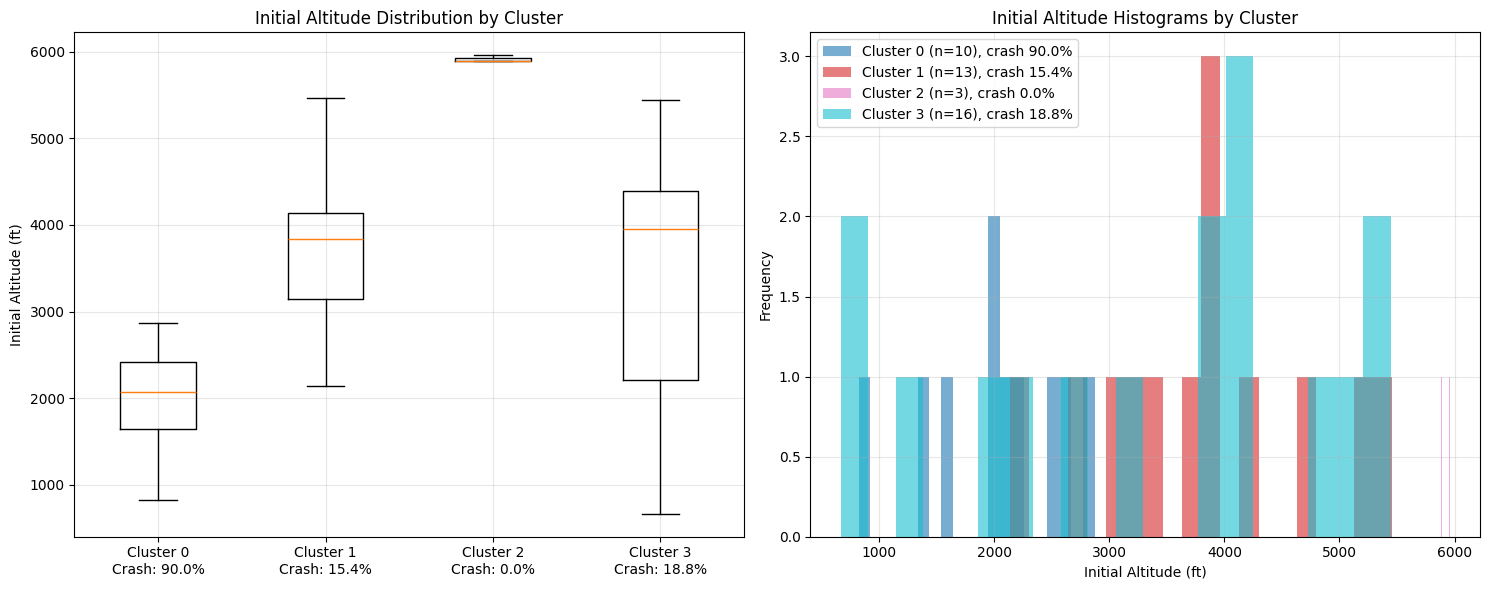

In [16]:
# Visualize altitude distributions by cluster
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Box plot of altitude by cluster
cluster_alts = []
cluster_labels = []
for cluster_id in unique_clusters:
    cluster_mask = clusters == cluster_id
    cluster_results = [
        valid_results[i] for i in range(len(valid_results)) if cluster_mask[i]
    ]
    cluster_altitudes = [r.test_case.ownship_alt for r in cluster_results]
    crashed_count = sum(1 for r in cluster_results if r.crashed)
    total_count = len(cluster_results)
    crash_rate = (crashed_count / total_count) * 100 if total_count > 0 else 0.0
    cluster_alts.append(cluster_altitudes)
    cluster_labels.append(f"Cluster {cluster_id}\nCrash: {crash_rate:.1f}%")

ax1.boxplot(cluster_alts, tick_labels=cluster_labels)
ax1.set_ylabel("Initial Altitude (ft)")
ax1.set_title("Initial Altitude Distribution by Cluster")
ax1.grid(True, alpha=0.3)

# Histogram of altitude distributions
colors = plt.get_cmap("tab10")(np.linspace(0, 1, len(unique_clusters)))
for i, cluster_id in enumerate(unique_clusters):
    cluster_mask = clusters == cluster_id
    cluster_results = [
        valid_results[i] for i in range(len(valid_results)) if cluster_mask[i]
    ]
    cluster_altitudes = [r.test_case.ownship_alt for r in cluster_results]
    crashed_count = sum(1 for r in cluster_results if r.crashed)
    total_count = len(cluster_results)
    crash_rate = (crashed_count / total_count) * 100 if total_count > 0 else 0.0

    ax2.hist(
        cluster_altitudes,
        bins=20,
        alpha=0.6,
        label=f"Cluster {cluster_id} (n={len(cluster_altitudes)}), crash {crash_rate:.1f}%",
        color=colors[i % len(colors)],
    )

ax2.set_xlabel("Initial Altitude (ft)")
ax2.set_ylabel("Frequency")
ax2.set_title("Initial Altitude Histograms by Cluster")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Variable -> Crash relationship summary
--------------------------------------------------
Altitude (ft)    | corr=-0.303 | AUC=0.686 | safe mean=3679.87 | crash mean=2730.36
Velocity (ft/s)  | corr=+0.307 | AUC=0.668 | safe mean=593.18 | crash mean=663.54
Alpha (deg)      | corr=-0.004 | AUC=0.531 | safe mean=5.36 | crash mean=5.34
Beta (deg)       | corr=-0.398 | AUC=0.735 | safe mean=4.08 | crash mean=-6.05
Phi (deg)        | corr=+0.014 | AUC=0.520 | safe mean=-17.91 | crash mean=-15.00
Theta (deg)      | corr=-0.297 | AUC=0.679 | safe mean=-36.84 | crash mean=-51.18
Power            | corr=+0.000 | AUC=0.500 | safe mean=9.00 | crash mean=9.00


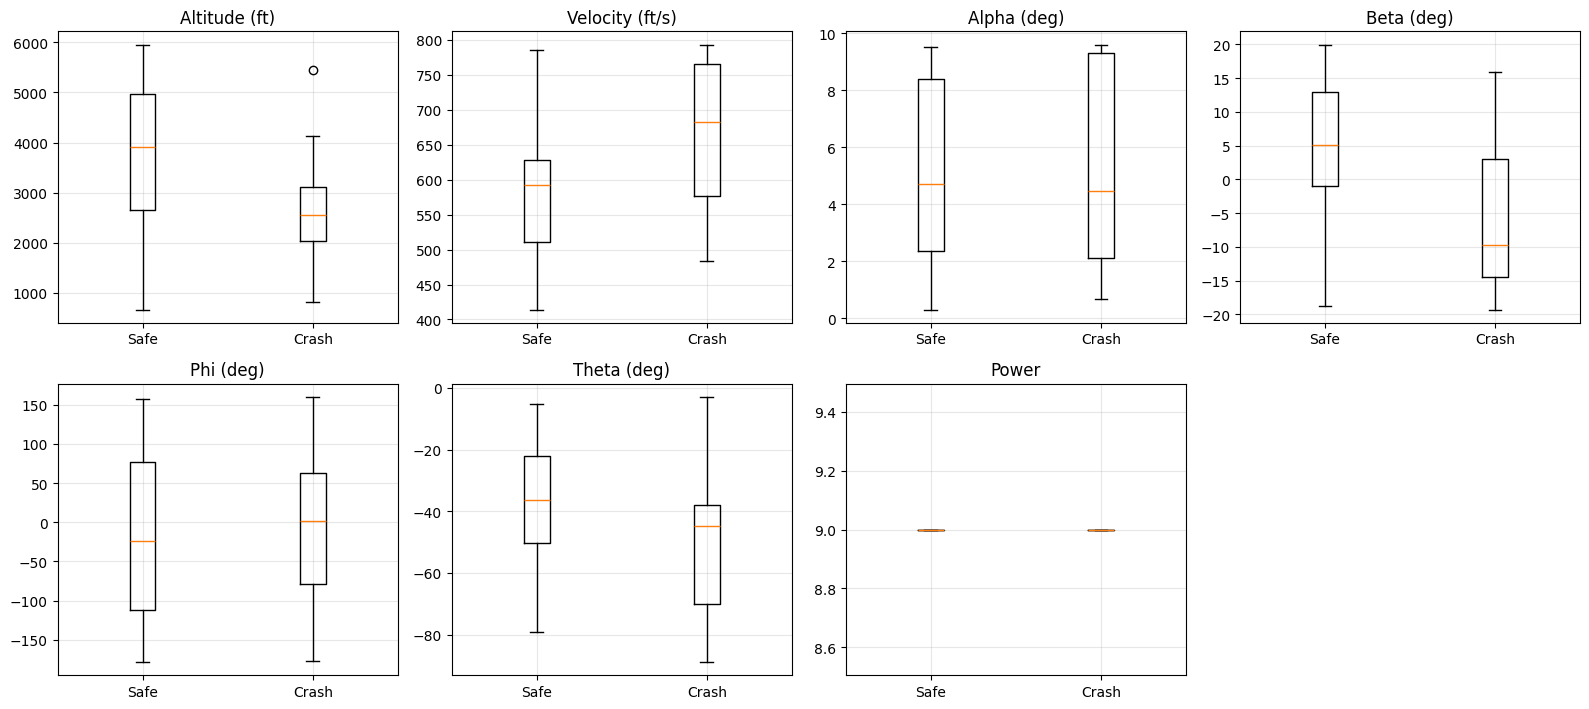

In [17]:
# Relationship of initial variables to crash outcome
from sklearn.metrics import roc_auc_score

# Collect initial variables and crash labels
labels = np.array([1 if r.crashed else 0 for r in valid_results])
vars_dict = {
    "Altitude (ft)": np.array([r.test_case.ownship_alt for r in valid_results]),
    "Velocity (ft/s)": np.array([r.test_case.ownship_vt for r in valid_results]),
    "Alpha (deg)": np.rad2deg(np.array([r.test_case.ownship_alpha for r in valid_results])),
    "Beta (deg)": np.rad2deg(np.array([r.test_case.ownship_beta for r in valid_results])),
    "Phi (deg)": np.rad2deg(np.array([r.test_case.ownship_phi for r in valid_results])),
    "Theta (deg)": np.rad2deg(np.array([r.test_case.ownship_theta for r in valid_results])),
    "Power": np.array([r.test_case.ownship_power for r in valid_results]),
}

print("Variable -> Crash relationship summary")
print("-" * 50)
for name, values in vars_dict.items():
    # Pearson correlation with binary label (point-biserial equivalent)
    corr = float(np.corrcoef(values, labels)[0, 1]) if np.std(values) > 0 else 0.0
    # ROC AUC for using the variable as a predictor (direction-agnostic)
    # We flip sign if AUC < 0.5 to report max separability
    try:
        auc_val = roc_auc_score(labels, values)
        auc = float(auc_val)
        auc = max(auc, 1.0 - auc)
    except Exception:
        auc = float("nan")

    safe_vals = values[labels == 0]
    crash_vals = values[labels == 1]
    print(
        f"{name:16s} | corr={corr:+.3f} | AUC={auc:.3f} | safe mean={np.mean(safe_vals):.2f} | crash mean={np.mean(crash_vals):.2f}"
    )

# Boxplots comparing crashed vs safe for each variable
num_vars = len(vars_dict)
cols = 4
rows = int(np.ceil(num_vars / cols))
fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3.6 * rows))
axes = axes.flatten()

for ax, (name, values) in zip(axes, vars_dict.items()):
    data = [values[labels == 0], values[labels == 1]]
    ax.boxplot(data, tick_labels=["Safe", "Crash"])
    ax.set_title(name)
    ax.grid(True, alpha=0.3)

# Hide any unused subplots
for j in range(len(vars_dict), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()